In [1]:
import gurobipy as gb
import numpy as np
import matplotlib.pyplot as plt
from pickle import load, dump
from ipywidgets import widgets, interactive_output
from IPython.display import display
from scipy.stats import ttest_ind

''' 
   Parameters setting
'''
h = 8; c = 5*h; f = 2*15*h

# Results

In [2]:
def check_objectives(it, T, G, S, phi, f, h, y, I, ntabs=0):

    objs = [sum(f*y[o][t] + h*sum(phi[s]*sum(I[o][s][t,g] for g in G) for s in S) for t in T) for o in [0,1]]
    if round(objs[0],4) != round(objs[1],4): print("\t"*ntabs + f"{it} Objectives differ. Standard = {round(objs[0],2)}. Transp. = {round(objs[1],2)}")

def show_age_sl_results(T, G, S, alpha, d, y, z, show=True):
    fig, axes = plt.subplots(nrows=len(G), ncols=len(T)+3, figsize=(22, 4))
    fig.subplots_adjust(wspace=0, hspace=0)

    sl = dict(); total_sl = dict(); cm = plt.get_cmap("RdYlGn")
    for g in G:
        for t in T:
            sl[t,g] = [sum(z[s][t,k] for k in range(g+1))/d[s][t] for s in S]
            axes[g][t+2].hist(sl[t,g], bins=[i/10  for i in range(10)]+[1.01], color=cm(sum(sl[t,g])/len(S)), alpha=1)
            axes[g][t+2].set_xlim(-0.2, 1.2); axes[g][t+2].set_ylim(-5,len(S)+5)
            axes[g][t+2].set_yticks([]); axes[g][t+2].set_xticks([0,0.25,0.5,0.75,1]); axes[g][t+2].set_xticklabels([])
            axes[g][t+2].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(sl[t,g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        
        axes[g][0].spines[["bottom","top","left","right"]].set_visible(False); axes[g][2].spines[["bottom","top","left","right"]].set_visible(False)
        axes[g][0].set_xlim(0,2); axes[g][2].set_xlim(0,2)
        axes[g][0].set_ylim(0,2); axes[g][0].set_xticks([]); axes[g][0].set_yticks([])
        axes[g][2].set_ylim(0,2); axes[g][2].set_xticks([]); axes[g][2].set_yticks([])
        axes[g][0].text(x=1, y=1, s=f"g = {g}\n"+fr"$\alpha_{g}$ = {alpha[g]:.0%}", va="center", ha="center", fontsize=11)

        total_ix = 1
        total_sl[g] = [sum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S]
        axes[g][total_ix].hist(total_sl[g], bins=[i/10 for i in range(11)], color = cm(sum(total_sl[g])/len(S)), alpha = 1)
        axes[g][total_ix].set_xlim(-0.2, 1.2); axes[g][total_ix].set_ylim(-5,len(S)+5)
        axes[g][total_ix].set_yticks([]); axes[g][total_ix].set_xticks([0,0.25,0.5,0.75,1]); axes[g][total_ix].set_xticklabels([])
        axes[g][total_ix].text(x=0.5, y=len(S)/2+2.5, s=f"{sum(total_sl[g])/len(S):.0%}", va="center", ha="center", fontsize=12)
        if round(sum(total_sl[g])/len(S),4) == alpha[g]:
            axes[g][total_ix].vlines(x = [-0.15, 1.15], ymin=-5, ymax=len(S)+5, linewidth=5, color="gold")
            axes[g][total_ix].hlines(y = [-2.5, len(S)+2.5], xmin=-0.2, xmax=1.2, linewidth=5, color="gold")
        axes[g][total_ix].vlines(x=1.2, ymin=-5, ymax=len(S)+5, color="black")
        
    for t in [0]+T:
        if t in T:
            if y[t]: col = "midnightblue"; weight = "bold"
            else: col = "black"; weight = "normal"
            axes[0][t+2].set_title(f"t = {t}", color=col, fontweight=weight)
            axes[-1][t+2].set_xticklabels(["0","","50","","100"], fontsize=8)
        else:
            axes[0][total_ix].set_title("Total"); axes[-1][total_ix].set_xticklabels(["0","","50","","100"], fontsize=8)

    fig.suptitle("Total age-dependent service level constraints analysis", fontsize=16, y = 1.05)

    if not show: plt.close()

    return sl, total_sl

def waste_level_analysis(T, G, S, a0, an1, n, x, I, show = True):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16,6), width_ratios=[6,2,6,2])
    fig.subplots_adjust(hspace=0.25)

    waste = dict()

    cm = plt.get_cmap("nipy_spectral")
    for a in a0:

        for b in an1:
            if a <= b:
                waste[a,b] = [sum(I[a,b][s][t,n-1] for t in T)/sum(x[a,b][t] for t in T) for s in S]

        col = cm((a-a0[0])/(a0[-1]-a0[0]))
        axes[0].plot([b for b in an1 if a <= b], [sum(waste[a,b])/len(S) for b in an1 if a <= b], color=col, marker="X", markersize=4)

    ub = int(np.ceil(sum(waste[a0[-1],an1[-1]])/(0.05*len(S))))
    ticks = [i*0.05*ub/5 for i in range(6)]
    axes[0].set_yticks(ticks); axes[0].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[0].set_ylim(0,ticks[-1])

    axes[0].set_title("Total waste level",fontsize=16)
    axes[0].set_xlim(an1[0]-0.025, an1[-1]+0.025)
    axes[0].spines[["top","right"]].set_visible(False)
    axes[0].set_xticks(an1)
    axes[0].set_xticklabels([f"{b:.0%}" if b*100 % 5 == 0 else "" for b in an1], fontsize=12)
    axes[0].set_xlabel("Total service level target",fontsize=12)

    ix = 1
    for a in a0:
        col = cm((a-a0[0])/(a0[-1]-a0[0])); tcol = "black"
        axes[1].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth = 4)
        axes[1].text(x=2.5, y=ix, s=f"{a:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[1].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{0}$", va="center", ha="center", fontsize=20)
    axes[1].set_xlim(0.5, 6)
    axes[1].set_ylim(-1, ix+2)
    axes[1].set_yticks([]); axes[1].set_xticks([])

    cm = plt.get_cmap("plasma")
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9)
        axes[2].plot([a for a in a0 if a <= b], [sum(waste[a,b])/len(S) for a in a0 if a <= b], color=col, marker="X", markersize=4)

    axes[2].set_yticks(ticks); axes[2].set_yticklabels([f"{a:.0%}" for a in ticks], fontsize=12); axes[2].set_ylim(0,ticks[-1])

    axes[2].set_title("Total waste level",fontsize=16)
    axes[2].set_xlim(a0[0]-0.025, a0[-1]+0.025)
    axes[2].spines[["top","right"]].set_visible(False)
    axes[2].set_xticks(a0)
    axes[2].set_xticklabels([f"{a:.0%}" if a*100 % 10 == 0 else "" for a in a0], fontsize=12)
    axes[2].set_xlabel("Fresh produce service level target",fontsize=12)

    ix = 1
    for b in an1:
        col = cm((an1[-1]-b)/(an1[-1]-an1[0])*0.9); tcol = "black"
        axes[3].hlines(y=[ix], xmin=1, xmax=2, color=col, linewidth=4)
        axes[3].text(x=2.5, y=ix, s=f"{b:.1%}", ha="left", va="center", fontsize=18, color=tcol)
        ix += 1
    axes[3].text(x=3.25, y=ix+0.75, s=fr"$\alpha_{G[-1]}$", va="center", ha="center", fontsize=20)
    axes[3].set_xlim(0.5, 6)
    axes[3].set_ylim(-1, ix+2)
    axes[3].set_yticks([]); axes[3].set_xticks([])

    fig.suptitle("Total waste level analysis", y=1, fontsize=18)

    if not show: plt.close()

    return waste

def period_fill_rate_analysis(T, G, S, a0, an1, d, z, show=True):


    nrows = int(np.ceil((len(an1))/3))
    fig, subp = plt.subplots(nrows=nrows, ncols=3, figsize=(24,4*nrows))
    fig.subplots_adjust(hspace = 0.25)

    ncharts = int(nrows*3)
    if ncharts > 3: axes = [subp[int(np.floor(ix/3)),ix%3] for ix in range(ncharts)]

    cm = plt.get_cmap("nipy_spectral")
    ix = 0; period_sl = dict()
    for b in an1:

        axes[ix].hlines(y=[b], xmin=-0.5, xmax=len(a0)-0.5, color="silver", linestyle="--")
        pos = 0
        for a in a0:
            if a <= b:
                
                col = cm((a-a0[0])/(a0[-1]-a0[0]))
                period_sl[a,b] = [sum(sum(z[a,b][s][t,g] for g in G)/d[s][t] for s in S)/len(S) for t in T]
                box = axes[ix].boxplot(x=period_sl[a,b], positions=[pos], widths=0.5, patch_artist = True)
                for item in ['boxes', 'whiskers', 'fliers', 'caps']:
                    plt.setp(box[item], color=col)
                plt.setp(box["medians"], color="white")
                plt.setp(box["fliers"], markeredgecolor=col)

            pos += 1
        
        axes[ix].text(x=pos-2.5, y=0.05, s=fr"$\alpha_{G[-1]}$ = {b:.1%}", fontsize=16, va="center", ha="center")
        
        ticks = [f"{a:.0%}" for a in a0 if a <= b]
        axes[ix].set_xticks([i for i in range(len(ticks))]); axes[ix].set_xticklabels(ticks, fontsize=12)
        
        ticks = [i/5 for i in range(6)]
        axes[ix].set_yticks(ticks); axes[ix].set_yticklabels([f"{t:.0%}" for t in ticks], fontsize=12)
        
        ix += 1

    for ax in axes[:len(an1)]:
        ax.set_xlim(-0.5, len(a0)-0.5)
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlabel("Fresh produce service level requirement", fontsize=12)

    if len(an1)+1 < ncharts:
        for m in range(len(an1), ncharts):
            axes[m].spines[["bottom","top","left","right"]].set_visible(False)
            axes[m].set_xticks([]); axes[m].set_yticks([])

    fig.suptitle("Fill rate per time period analysis", y=0.925, fontsize=16)

    if not show: plt.close()

    return period_sl



In [3]:
def print_transportation_summary(mm, setup, prod, hold, T, G, S, Tt, n, d, q, x, r, l, w, v, ntabs=0):

    print("\n"+"\t"*ntabs+f"Objective: {mm.objVal:.2f}. Runtime: {mm.runTime:.5f}")
    print("\t"*ntabs+f"\tSetup cost: {setup.getValue():.2f}")
    print("\t"*ntabs+f"\tProduction cost: {prod.getValue():.2f}")
    print("\t"*ntabs+f"\tHolding cost: {hold.getValue():.2f}\n")

    for s in S:
        print("\n"+"\t"*ntabs+f"Scenario {s}")

        print("\t"*(ntabs+1)+" ", *[" "*(5-len(str(t)))+str(t) for t in T], "Total", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"d", *[" "*(5-len(f"{d[s][t]:.1f}"))+f"{d[s][t]:.1f}" for t in T], " "*(5-len(f"{sum(d[s][t] for t in T):.1f}"))+f"{sum(d[s][t] for t in T):.1f}", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"q", *[" "*(5-len(f"{q[t]:.1f}"))+f"{q[t]:.1f}" if q[t] > 0 else "    ." for t in T], " "*(5-len(f"{sum(q[t] for t in T):.1f}"))+f"{sum(q[t] for t in T):.1f}", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        for g in G[:-1]:
            print("\t"*(ntabs+1)+f"r{g}", *[(" "*(5-len(f"{r[s][t,g]:.1f}"))+f"{r[s][t,g]:.1f}" if round(r[s][t,g],1) > 0 else "    .") if t in range(1, n-g-1 + 1) else "     " for t in T], sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        for t in T:
            print("\t"*(ntabs+1)+f"x{t}", *[(" "*(5-len(f"{x[s][t,m]:.1f}"))+f"{x[s][t,m]:.1f}" if x[s][t,m] > 0 else "    .") if m in Tt[t] else "     " for m in T], sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        print("\t"*(ntabs+1)+"l", *[" "*(5-len(f"{l[s][t]:.1f}"))+f"{l[s][t]:.1f}" if round(l[s][t],1) > 0 else "    ." for t in T], " "*(5-len(f"{sum(l[s][t] for t in T):.1f}"))+f"{sum(l[s][t] for t in T):.1f}", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"w", *[" "*(5-len(f"{w[s][t]:.1f}"))+f"{w[s][t]:.1f}" if round(w[s][t],1) > 0 else "    ." for t in T], " "*(5-len(f"{sum(w[s][t] for t in T):.1f}"))+f"{sum(w[s][t] for t in T):.1f}", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"v", *[(" "*(5-len(f"{v[s][t]:.1f}"))+f"{v[s][t]:.1f}" if round(v[s][t],1) > 0 else "    .") if t+n-1>T[-1] else "     " for t in T], " "*(5-len(f"{sum(v[s][t] for t in T if t+n-1>T[-1]):.1f}"))+f"{sum(v[s][t] for t in T if t+n-1>T[-1]):.1f}", sep="\t")

def print_summary(m, T, G, S, f, c, h, d, y, x, z, l, w, I, ntabs = 0, fifo = None):

    print("\n"+"\t"*ntabs+f"Objective: {round(m.getObjective().getValue(),2)}\tRuntime: {round(m.RunTime,5)}")
    print("\t"*ntabs+f"\tSetup cost: {round(sum(f*y[t] for t in T),2)}")
    print("\t"*ntabs+f"\tProduction cost: {round(sum(c*x[t] for t in T),2)}")
    print("\t"*ntabs+f"\tHolding cost: {round(sum(sum(h*I[s][t,g] for t in T for g in G) for s in S)/len(S),2)}")

    for s in S:
        print("\n"+"\t"*ntabs+f"Scenario {s}")
        print("\t"*(ntabs+1)+" ", *[" "*(5-len(str(t)))+str(t) for t in T], "Total", sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"d", *[" "*(5-len(str(round(d[s][t],1))))+str(round(d[s][t],1)) for t in T], " "*(5-len(str(round(sum(d[s][t] for t in T),1))))+str(round(sum(d[s][t] for t in T),1)), sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        print("\t"*(ntabs+1)+"x", *[" "*(5-len(str(round(x[t],1))))+str(round(x[t],1)) if round(x[t],1) > 0 else "    ." for t in T], " "*(5-len(str(round(sum(x[t] for t in T),1))))+str(round(sum(x[t] for t in T),1)), sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        for g in G:
            print("\t"*(ntabs+1)+f"z{g}", *[" "*(5-len(str(round(z[s][t,g],1))))+str(round(z[s][t,g],1)) if round(z[s][t,g],1) > 0 else "    ." for t in T],  " "*(5-len(str(round(sum(z[s][t,g] for t in T),1))))+str(round(sum(z[s][t,g] for t in T),1)), sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
        
        print("\t"*(ntabs+1)+"l", *[" "*(5-len(str(round(l[s][t],1))))+str(round(l[s][t],1)) if round(l[s][t],1) > 0 else "    ." for t in T], " "*(5-len(str(round(sum(l[s][t] for t in T),1))))+str(round(sum(l[s][t] for t in T),1)), sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        for g in G[:-1]:
            print("\t"*(ntabs+1)+f"I{g}", *[" "*(5-len(str(round(I[s][t,g],1))))+str(round(I[s][t,g],1)) if round(I[s][t,g],1) > 0 else "    ." for t in T],  " "*(5-len(str(round(sum(I[s][t,g] for t in T),1))))+str(round(sum(I[s][t,g] for t in T),1)), sep="\t")
        print("\t"*(ntabs+1)+"-"*8*(3+len(T)))

        print("\t"*(ntabs+1)+"w", *[" "*(5-len(str(round(w[s][t],1))))+str(round(w[s][t],1)) if round(w[s][t],1) > 0 else "    ." for t in T], " "*(5-len(str(round(sum(w[s][t] for t in T),1))))+str(round(sum(w[s][t] for t in T),1)), sep="\t")

        if fifo is not None:
            print("\t"*(ntabs+1)+"-"*8*(3+len(T)))
            print("\t"*(ntabs+1)+"a", *[" "*(5-len(str(round(fifo[0][s][t].x,1))))+str(round(fifo[0][s][t].x,1)) for t in T], sep="\t")
            print("\t"*(ntabs+1)+"b", *[" "*(5-len(str(round(fifo[1][s][t].x,1))))+str(round(fifo[1][s][t].x,1)) for t in T], sep="\t")

    print("\n"+"\t"*ntabs+f"Exp. fresh fill rate: {sum(sum(z[s][t,0] for t in T)/sum(d[s][t] for t in T) for s in S)/len(S):.1%}, Exp. total fill rate: {sum(sum(z[s][t,g] for t in T for g in G)/sum(d[s][t] for t in T) for s in S)/len(S):.1%}")


# Models

In [4]:
def stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = 0, output = False, verbose = False, time = False, threads=0):

    m = gb.Model("Standard Model")
    Tt = {t:[mm for mm in range(np.max((1,t)),np.min((T[-1],t+n-1)) + 1)] for t in T+[-tt for tt in range(n)]}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Produced quantity in period t \in T
    x = {t:m.addVar(name=f"x_{t}", vtype=gb.GRB.CONTINUOUS) for t in T}
    # Amount of product of age g \in G that is used to fulfill demand in period t \in T
    z = {s:{(t,g):m.addVar(name=f"z_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    # Lost sales of period t \in T
    l = {s:{t:m.addVar(name=f"l_{s,t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Available inventory of product of age g \in G at the end of period t \in T
    I = {s:{(t,g):m.addVar(name=f"I_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    for s in S: I[s].update({(0,g):I0[g] for g in I0})

    ######################################
    # CONSTRAINTS
    ######################################

    for t in T:

        # Production capacity
        m.addConstr(x[t] <= np.min((C, np.max([sum(d[s][mm] for mm in Tt[t]) for s in S]) ))*y[t])

        for s in S:
            # Inventory of fresh produce
            m.addConstr(I[s][t,0] == x[t] - z[s][t,0])

            for g in G[1:]:
                # Inventory dynamics throughout the day   
                m.addConstr(I[s][t,g] == I[s][t-1,g-1] - z[s][t,g])

            # Demand fulfillment and lost sales modeling
            m.addConstr(gb.quicksum(z[s][t,g] for g in G) + l[s][t] == d[s][t])
        
        # Expected demand service level by time period
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,g] for g in G)/d[s][t] for s in S) >= beta)
    
    for g in G:
        # Total age service level constraint
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S) >= alpha[g])
    
    # Total waste control constraint
    m.addConstr(gb.quicksum(phi[s]*gb.quicksum(I[s][t,n-1] for t in T) for s in S) <= epsilon*gb.quicksum(x[t] for t in T))

    # FIFO constraints
    if FIFO == 1:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G:
                    m.addConstr(I[s][t,g] <= C*(1-gamma[s][t,g]))

                    if g < G[-1]:
                        m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])
    elif FIFO == 2:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}
        delta = {s:{t:m.addVar(name=f"delta_{s,t}",vtype=gb.GRB.BINARY) for t in T} for s in S}
        a = {s:{t:m.addVar(name=f"a_{s,t}",vtype=gb.GRB.CONTINUOUS,lb=-n) for t in T} for s in S}
        b = {s:{t:m.addVar(name=f"b_{s,t}",vtype=gb.GRB.CONTINUOUS,lb=-n) for t in T} for s in S}

        for s in S:
            for t in T:
                m.addConstr(gb.quicksum(gamma[s][t,g] for g in G)/n <= delta[s][t])
                m.addConstr(delta[s][t] <= gb.quicksum(gamma[s][t,g] for g in G))

                for g in G:
                    m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g])
                    
                    if g > 0:
                        m.addConstr(gb.quicksum(I[s][t,k] for k in G if k >= g) <= C*len([k for k in G if k >= g])*(1-gamma[s][t,g-1]))
                
                    m.addConstr(a[s][t] <= (t-g)*gamma[s][t,g] + t*(1-gamma[s][t,g]))
                    m.addConstr(b[s][t] >= (t-g)*gamma[s][t,g] + (t-n+1)*(1-gamma[s][t,g]))
                
                if t < T[-1]:
                    m.addConstr(b[s][t] <= a[s][t+1])
                m.addConstr(b[s][t] - a[s][t] == gb.quicksum(gamma[s][t,g] for g in G) - delta[s][t])


    ######################################
    # OBJECTIVE FUNCTION
    ######################################
    
    total_cost = gb.quicksum(f*y[t] + c*x[t] + h*gb.quicksum(phi[s]*gb.quicksum(I[s][t,g] for g in G) for s in S) for t in T)
    m.setObjective(total_cost)

    m.update()
    m.setParam("OutputFlag",output)
    m.setParam("MIPFocus",MIPFocus)
    m.setParam("Threads", threads)
    m.setParam("MIPGap",1e-5)
    m.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    if not time:
        y = {t:round(y[t].x) for t in T}
        x = {t:round(x[t].x,10) for t in T}
        z = {s:{(t,g):round(z[s][t,g].x,10) for t in T for g in G} for s in S}
        l = {s:{t:round(l[s][t].x,10) for t in T} for s in S}
        w = {s:{t:round(I[s][t,n-1].x,10) for t in T} for s in S}
        I = {s:{(t,g):round(I[s][t,g].x,10) for t in T for g in G} for s in S}

        if verbose:
            if FIFO == 2: print_summary(m, T, G, S, f, c, h, d, y, x, z, l, w, I, ntabs = 2, fifo=(a,b))
            else: print_summary(m, T, G, S, f, c, h, d, y, x, z, l, w, I, ntabs = 2)

        return y, x, z, l, w, I, m.objVal
    else:
        return m.runTime, m.getObjective().getValue()


def stat_dyn_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = 0, output = False, verbose = False, time = False, threads=0):

    m = gb.Model("Standard Model")
    Tt = {t:[mm for mm in range(np.max((1,t)),np.min((T[-1],t+n-1)) + 1)] for t in T+[-tt for tt in range(n)]}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in period t \in T or not
    y = {t:m.addVar(name=f"y_{t}", vtype=gb.GRB.BINARY) for t in T}
    # Produced quantity in period t \in T
    x = {s:{t:m.addVar(name=f"x_{t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Amount of product of age g \in G that is used to fulfill demand in period t \in T
    z = {s:{(t,g):m.addVar(name=f"z_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    # Lost sales of period t \in T
    l = {s:{t:m.addVar(name=f"l_{s,t}", vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Available inventory of product of age g \in G at the end of period t \in T
    I = {s:{(t,g):m.addVar(name=f"I_{s,t,g}", vtype=gb.GRB.CONTINUOUS) for t in T for g in G} for s in S}
    for s in S: I[s].update({(0,g):I0[g] for g in I0})

    ######################################
    # CONSTRAINTS
    ######################################

    for t in T:

        for s in S:

            # Production capacity
            m.addConstr(x[s][t] <= np.min((C, sum(d[s][m] for m in Tt[t])))*y[t])

            # Inventory of fresh produce
            m.addConstr(I[s][t,0] == x[s][t] - z[s][t,0])

            for g in G[1:]:
                # Inventory dynamics throughout the day   
                m.addConstr(I[s][t,g] == I[s][t-1,g-1] - z[s][t,g])

            # Demand fulfillment and lost sales modeling
            m.addConstr(gb.quicksum(z[s][t,g] for g in G) + l[s][t] == d[s][t])
        
        # Expected demand service level by time period
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,g] for g in G)/d[s][t] for s in S) >= beta)
    
    for g in G:
        # Total age service level constraint
        m.addConstr(gb.quicksum(phi[s]*gb.quicksum(z[s][t,k] for t in T for k in range(g+1))/sum(d[s][t] for t in T) for s in S) >= alpha[g])
    
    # Total waste control constraint
    m.addConstr(gb.quicksum(phi[s]*gb.quicksum(I[s][t,n-1] for t in T)/(alpha[n-1]*sum(d[s][t] for t in T)) for s in S) <= epsilon)

    # FIFO constraints
    if FIFO == 1:
        gamma = {s:{(t,g):m.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G:
                    m.addConstr(I[s][t,g] <= C*(1-gamma[s][t,g]))

                    if g < G[-1]:
                        m.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                        m.addConstr(z[s][t,g] <= d[s][t]*gamma[s][t,g+1])

    ######################################
    # OBJECTIVE FUNCTION
    ######################################
    
    total_cost = gb.quicksum(f*y[t] + c*gb.quicksum(phi[s]*x[s][t] for s in S) + h*gb.quicksum(phi[s]*gb.quicksum(I[s][t,g] for g in G) for s in S) for t in T)
    m.setObjective(total_cost)

    m.update()
    m.setParam("OutputFlag",output)
    m.setParam("MIPFocus",MIPFocus)
    m.setParam("Threads", threads)
    m.setParam("MIPGap",1e-5)
    m.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    if not time:
        y = {t:round(y[t].x) for t in T}
        x = {s:{t:round(x[s][t].x,10) for t in T} for s in S}
        z = {s:{(t,g):round(z[s][t,g].x,10) for t in T for g in G} for s in S}
        l = {s:{t:round(l[s][t].x,10) for t in T} for s in S}
        w = {s:{t:round(I[s][t,n-1].x,10) for t in T} for s in S}
        I = {s:{(t,g):round(I[s][t,g].x,10) for t in T for g in G} for s in S}

        if verbose:
            print(f"\tObjective: {round(total_cost.getValue(),2)}")
            print(f"\t\tSetup: {f*sum(y[t] for t in T)}")
            print(f"\t\tExp. Holding: {h*sum(phi[s]*sum(I[s][t,g] for t in T for g in G) for s in S)}")
            print(f"\tRuntime: {round(m.runTime,4)}\n")

        return y, x, z, l, w, I
    else:
        return m.runTime, m.getObjective().getValue()


def stat_stat_transportation_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta = 0, epsilon = 1, MIPFocus = 0,  FIFO = False, output = False, verbose = False, time = False):

    mm = gb.Model("Standard Model")
    Tt = {t:[m for m in range(t,np.min((T[-1],t+n-1)) + 1)] for t in T}

    cw = {t:0 if t<=n-1 else c for t in T}
    hx = {(t,m):h*(m-t) for t in T for m in Tt[t]}
    hw = {t:h*t if t <= n-1 else h*n for t in T}
    hr = {t:h*(t-1) for t in T}
    hv = {t:h*(T[-1]-t+1) for t in T if t+n-1>T[-1]}

    ######################################
    # DECISION VARIABLES
    ######################################

    # Whether there is production in time period t \in T or not
    y = {t:mm.addVar(name=f"y_{t}",vtype=gb.GRB.BINARY) for t in T}
    # Total production in time period t \in T
    q = {t:mm.addVar(name=f"q_{t}",vtype=gb.GRB.CONTINUOUS) for t in T}
    # Production quantity of time period t \in T that is used to satisfy demand in time period m \in T_t
    x = {s:{(t,m):mm.addVar(name=f"x_{s,t,m}",vtype=gb.GRB.CONTINUOUS) for t in T for m in Tt[t]} for s in S}
    # Amount of initial inventory of age g \in G - {n-1} used to fulfill demand in time period t \in {1, ..., n-g-1}
    r = {s:{(t,g):mm.addVar(name=f"r_{s,t,g}",vtype=gb.GRB.CONTINUOUS) for g in G[:-1] for t in range(1,n-g)} for s in S}
    # Generated waste in time period t \in T
    w = {s:{t:mm.addVar(name=f"w_{s,t}",vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}
    # Leftover product at the end of the planning horizon that was produced in time period t \in T
    v = {s:{t:mm.addVar(name=f"v_{s,t}",vtype=gb.GRB.CONTINUOUS) for t in T} for s in S}

    ######################################
    # CONSTRAINTS
    ######################################      
    
    for t in T:
        mm.addConstr(q[t] <= np.min((C,np.max([sum(d[s][m] for m in Tt[t]) for s in S])))*y[t])

    for s in S:

        for g in G[:-1]:
            # Initial inventory modeling
            mm.addConstr(I0[g] == gb.quicksum(r[s][t,g] for t in range(1, n-g-1 + 1)) + w[s][n-g-1])
        
        for t in T:
            # Demand modeling
            if t <= n-1:
                mm.addConstr(gb.quicksum(r[s][t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[s][j,t] for j in range(1, t+1)) <= d[s][t])
            else:
                mm.addConstr(gb.quicksum(x[s][j,t] for j in range(t-n+1, t+1)) <= d[s][t])
            
            # Production capacity constraints
            if t+n-1 <= T[-1]:
                mm.addConstr(q[t] == gb.quicksum(x[s][t,m] for m in Tt[t]) + w[s][t+n-1])
            else:
                mm.addConstr(q[t] == gb.quicksum(x[s][t,m] for m in Tt[t]) + v[s][t])
            
            for m in Tt[t]:
                mm.addConstr(x[s][t,m] <= np.min((C,d[s][m]))*y[t])

    # Age service level constraints
    mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(x[s][t,t] for t in T)/sum(d[s][t] for t in T) for s in S) >= alpha[0])
    mm.addConstr(gb.quicksum(phi[s]*(gb.quicksum(x[s][t,m] for (t,m) in x[s]) + gb.quicksum(r[s][t,g] for (t,g) in r[s]))/sum(d[s][t] for t in T) for s in S) >= alpha[n-1])
    
    # Demand service level per time period
    for t in T:
        if t <= n-1:
            mm.addConstr(gb.quicksum(phi[s]*(gb.quicksum(r[s][t,g] for g in range(n-t-1 + 1)) + gb.quicksum(x[s][j,t] for j in range(1, t+1)))/d[s][t] for s in S) >= beta)
        else:
            mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(x[s][j,t] for j in range(t-n+1, t+1))/d[s][t] for s in S) >= beta)

    if FIFO == 1:
        gamma = {s:{(t,g):mm.addVar(name=f"gamma_{s,t,g}",vtype=gb.GRB.BINARY) for t in T for g in G} for s in S}

        for s in S:
            for t in T:
                for g in G[:-1]:
                    
                    # Days and ages for which initial inventory can be stored
                    if t-g<=0:
                        mm.addConstr(sum(r[s][j,g-t] for j in range(t+1, (n-1)-(g-t) + 1)) + w[s][(n-1)-(g-t)] <= C*(1-gamma[s][t,g]))
                    # Days and ages with waste within the planning horizon
                    elif t-g <= T[-1]-n+1:
                        mm.addConstr(sum(x[s][t-g, m] for m in Tt[t-g] if m > t) + w[s][(n-1)+(t-g)] <= C*(1-gamma[s][t,g]))
                    # Days and ages with waste beyond the planning horizon
                    elif t < T[-1]:
                        mm.addConstr(sum(x[s][t-g, m] for m in Tt[t-g] if m > t) + v[s][t-g] <= C*(1-gamma[s][t,g]))
                    
                    mm.addConstr(gamma[s][t,g] <= gamma[s][t,g+1])
                    if t-g <= 0:
                        mm.addConstr(r[s][t,g-t] <= d[s][t]*gamma[s][t,g+1])
                    else:
                        mm.addConstr(x[s][t-g,t] <= d[s][t]*gamma[s][t,g+1])
                
                # Inventory of oldest age (waste)
                mm.addConstr(w[s][t] <= C*(1-gamma[s][t,G[-1]]))
                # Leftover inventory in the last time period
                for g in G[:-1]:
                    mm.addConstr(v[s][T[-1]-g] <= C*(1-gamma[s][t,g]))

    # Waste control constraint
    mm.addConstr(gb.quicksum(phi[s]*gb.quicksum(w[s][t] for t in T) for s in S) <= epsilon*(gb.quicksum(q[t] for t in T)))

    ######################################
    # OBJECTIVE FUNCTION
    ######################################
    
    setup_cost = gb.quicksum(f*y[t] for t in T)
    production_cost = gb.quicksum(c*q[t] for t in T)
    holding_cost = gb.quicksum(phi[s]*(gb.quicksum(gb.quicksum(hx[t,m]*x[s][t,m] for m in Tt[t]) + hw[t]*w[s][t] + gb.quicksum(hr[t]*r[s][t,g-t] for g in G if t-g<=0) for t in T) + gb.quicksum(hv[t]*v[s][t] for t in T if t+n-1 > T[-1])) for s in S)
    mm.setObjective(setup_cost + production_cost + holding_cost)

    mm.update()
    mm.setParam("OutputFlag",output)
    mm.setParam("MIPFocus",MIPFocus)
    mm.setParam("MIPGap",1e-5)
    mm.optimize()

    ######################################
    # RESULTS RETRIEVING
    ######################################

    if not time:
        y = {t:round(y[t].x) for t in T}
        xx = {t:q[t].x for t in T}
        z = {s:{(t,g):x[s][t-g,t].x if t-g >= 1 else r[s][t,g-t].x for t in T for g in G} for s in S}
        l = {s:{t:d[s][t]-sum(z[s][t,g] for g in G) for t in T} for s in S}
        w = {s:{t:w[s][t].x for t in T} for s in S}
        v = {s:{t:v[s][t].x for t in T if t+n-1>T[-1]} for s in S}
        I = {s:{(0,g):I0[g] for g in I0} for s in S}
        for s in S:
            for t in T:
                for g in G[:-1]:

                    if t-g<=0: I[s][t,g] = sum(r[s][j,g-t].x for j in range(t+1, (n-1)-(g-t) + 1)) + w[s][(n-1)-(g-t)]
                    elif t-g <= T[-1]-n+1: I[s][t,g] = sum(x[s][t-g, m].x for m in Tt[t-g] if m > t) + w[s][(n-1)+(t-g)]
                    elif t < T[-1]: I[s][t,g] = sum(x[s][t-g, m].x for m in Tt[t-g] if m > t) + v[s][t-g]
                
                I[s][t,n-1] = w[s][t]

            for g in G[:-1]:
                I[s][T[-1],g] = v[s][T[-1]-g]

        x = {s:{(t,m):x[s][t,m].x for (t,m) in x[s]} for s in S}
        r = {s:{(t,g):r[s][t,g].x for (t,g) in r[s]} for s in S}

        if verbose:
            print_transportation_summary(mm, setup_cost, production_cost, holding_cost, T, G, S, Tt, n, d, xx, x, r, l, w, v, ntabs=2)
            print_summary(mm, T, G, S, f, c, h, d, y, xx, z, l, w, I, ntabs = 2)

        return y, xx, z, l, w, I, mm.objVal

    else:

        return mm.runTime, mm.objVal

# Formulations equivalence check

In [5]:
T = 10; S = 3; n = 4
T = list(range(1,T+1)); G = list(range(n)); S = list(range(1,S+1))

I0 = {g:10 for g in G[:-1]}; phi = {s:1/len(S) for s in S}
d = {s:{t:5+20*np.random.random() for t in T} for s in S}
C = 2*15

In [74]:
alpha = dict(); verbose = True; FIFO = 1
y1, x1, z1, l1, w1, I1, obj1 = dict(), dict(), dict(), dict(), dict(), dict(), dict()
y2, x2, z2, l2, w2, I2, obj2 = dict(), dict(), dict(), dict(), dict(), dict(), dict()

a0 = [0.2, 0.3]
an1 = [0.8, 0.95]

for a in a0:
    for b in an1:
        
        if a <= b:
            
            print(f"----- alpha(0): {a:.1%}, alpha(n-1): {b:.1%}")
            alp = [a if g < G[-1] else b for g in G]; alpha[a,b] = dict(zip(G,alp))

            _ = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=0, verbose=verbose)
            y1[a,b], x1[a,b], z1[a,b], l1[a,b], w1[a,b], I1[a,b], obj1[a,b] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=1, verbose=verbose)
            y2[a,b], x2[a,b], z2[a,b], l2[a,b], w2[a,b], I2[a,b], obj2[a,b] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=2, verbose=verbose)
            #y2[a,b], x2[a,b], z2[a,b], l2[a,b], w2[a,b], I2[a,b], obj2[a,b] = stat_stat_transportation_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha[a,b], MIPFocus = 2, FIFO=FIFO, verbose=verbose)

            if np.abs(obj1[a,b]-obj2[a,b])/np.min([obj1[a,b], obj2[a,b]]) > 1e-5:
                if obj2[a,b] < obj1[a,b]: message = "TF is lower"
                else: message = "SF is lower"
                print("\t"*2+f"{0} DIFFERENT OBJECTIVE VALUES - Standard: {obj1[a,b]}, Transportation: {obj2[a,b]}. {message}\n")
                


----- alpha(0): 20.0%, alpha(n-1): 80.0%

		Objective: 4592.31	Runtime: 0.037
			Setup cost: 720
			Production cost: 3397.41
			Holding cost: 474.9

		Scenario 1
			 	    1	    2	    3	    4	    5	    6	    7	    8	    9	   10	Total
			--------------------------------------------------------------------------------------------------------
			d	  6.3	  7.3	  7.9	 13.6	  5.0	 11.9	 23.7	  6.4	 20.8	  7.8	110.7
			--------------------------------------------------------------------------------------------------------
			x	    .	    .	    .	 26.4	    .	    .	 30.0	    .	 28.6	    .	 84.9
			--------------------------------------------------------------------------------------------------------
			z0	    .	    .	    .	 13.6	    .	    .	 23.7	    .	 20.8	    .	 58.1
			z1	  2.1	    .	    .	    .	  5.0	    .	    .	  6.3	    .	  7.8	 21.2
			z2	  2.7	    .	    .	    .	    .	  7.7	    .	    .	    .	    .	 10.4
			z3	  1.5	  7.3	  7.9	    .	    .	    .	    .	    .	    .	    .	 16.7
			----------

# Computational time

In [6]:
verbose = False; S = 3
a0 = [0]; an1 = [0.8, 0.9, 0.95, 0.975]
S = list(range(1,S+1)); phi = {s:1/len(S) for s in S}

t1, t2 = dict(), dict()
obj1, obj2 = dict(), dict()

for tt in [20, 30]:
    for n in [2, 4, 8]:

        print(f" |T| = {tt}, n = {n}")
        T = list(range(1,tt+1)); G = list(range(n)); I0 = {g:0 for g in G[:-1]}
        t1[tt,n], t2[tt,n] = {(a,b):dict() for a in a0 for b in an1}, {(a,b):dict() for a in a0 for b in an1}
        obj1[tt,n], obj2[tt,n] = {(a,b):dict() for a in a0 for b in an1}, {(a,b):dict() for a in a0 for b in an1}

        ix = 0
        while ix <= 24:
            
            try:
                d = {s:{t:5+20*np.random.random() for t in T} for s in S}
                C = 2*15

                for a in a0:
                    for b in an1:
                        
                        alpha = {g:b if g > 0 else a for g in G}

                        t1[tt,n][a,b][ix], obj1[tt,n][a,b][ix] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta=0, epsilon=1, FIFO = 1, verbose=verbose, time=True)
                        t2[tt,n][a,b][ix], obj2[tt,n][a,b][ix] = stat_stat_standard_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta=0, epsilon=1, FIFO = 2, verbose=verbose, time=True)

                        #t2[tt,n][a,b][ix], obj2[tt,n][a,b][ix] = stat_stat_transportation_model(T, G, S, phi, n, h, c, f, C, I0, d, alpha, beta=0, epsilon=1, FIFO = FIFO, verbose=verbose, time=True)
                ix += 1

            except:

                continue

            if (ix+1) % 5 == 0: print(f"\tDone {ix}")

 |T| = 20, n = 2
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-14
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24
 |T| = 20, n = 4
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24
 |T| = 20, n = 8
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24
 |T| = 30, n = 2
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24
 |T| = 30, n = 4
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24
 |T| = 30, n = 8
	Done 4
	Done 9
	Done 14
	Done 19
	Done 24


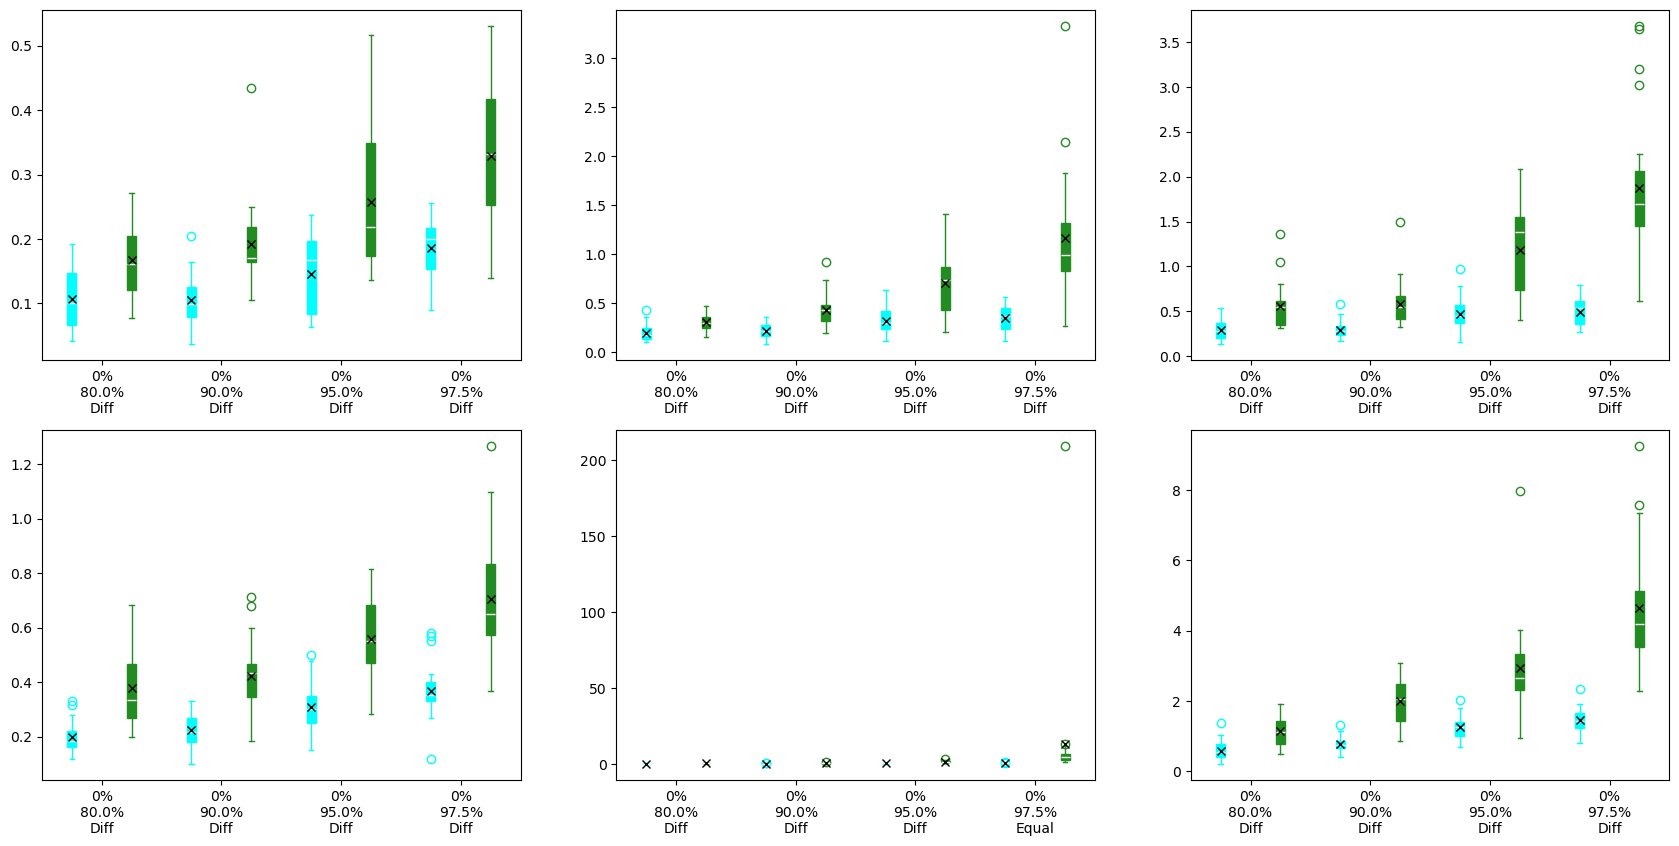

In [7]:
fig, sp = plt.subplots(nrows=2, ncols=3, figsize=(21,10))

T = [20, 30]; N = [2, 4, 8]
axes = {(t,n):sp[T.index(t),N.index(n)] for t in T for n in N}
alpha = [(a,b) for a in a0 for b in an1]

for t in T:
    for n in N:
        
        tests = dict()
        ix = 1
        for (a,b) in alpha:

            box = axes[t,n].boxplot(list(t1[t,n][a,b].values()), positions=[ix], patch_artist = True, showmeans=True, meanprops={"marker":"x"})
            for item in ["boxes", "whiskers", "fliers", "caps"]:
                plt.setp(box[item], color="cyan")
            plt.setp(box["fliers"], markeredgecolor="cyan")
            plt.setp(box["medians"], color="white")
            plt.setp(box["means"], markeredgecolor="black")

            box = axes[t,n].boxplot(list(t2[t,n][a,b].values()), positions=[ix+1], patch_artist = True, showmeans=True, meanprops={"marker":"x"})
            for item in ["boxes", "whiskers", "fliers", "caps"]:
                plt.setp(box[item], color="forestgreen")
            plt.setp(box["fliers"], markeredgecolor="forestgreen")
            plt.setp(box["medians"], color="white")
            plt.setp(box["means"], markeredgecolor="black")

            ix += 2

            _, tests[a,b] = ttest_ind(list(t1[t,n][a,b].values()), list(t2[t,n][a,b].values()), alternative="two-sided")

        axes[t,n].set_xticks([1.5+2*i for i in range(len(alpha))]); axes[t,n].set_xticklabels([f"{a:.0%}\n{b:.1%}\n{'Diff' if tests[a,b]<0.01 else 'Equal'}" for (a,b) in alpha])
        

